In [1]:
#default_exp christmas

# Christmas

This notebook includes the EDA used in determining whether to switch to a similar days method for the Christmas submission instead of the previous supervised learning approach.

*Spoiler*: The outputs were almost identical so we opted to keep the same approach used in other weeks for consistency.

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import os
from sklearn.ensemble import RandomForestRegressor

from batopt import clean, discharge, charge, constraints, pv

In [3]:
import FEAutils as hlp
import matplotlib.pyplot as plt

<br>

### User Inputs

In [4]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'

<br>

### Christmas Model EDA

We'll start by loading in the combined training dataset

In [5]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand,pv,weather,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,holidays
2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.75,9.650,8.830,7.580,11.620,11.22,NaN
2015-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.83,9.705,8.865,7.600,11.635,11.27,NaN
2015-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.91,9.760,8.900,7.620,11.650,11.32,NaN
2015-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.95,9.780,9.000,7.615,11.650,11.31,NaN
2015-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.99,9.800,9.100,7.610,11.650,11.30,NaN


<br>

We'll now create our charge/discharge baseline for 2018

<AxesSubplot:>

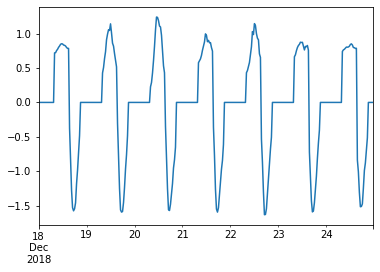

In [8]:
test_start_date = '2018-12-18'
test_end_date = '2018-12-24 23:59'

discharge_opt_model_fp = '../models/discharge_opt.sav'
pv_model_fp = '../models/pv_model.sav'

model_params = {
    'criterion': 'mse',
    'bootstrap': True,
    'max_depth': 32,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 74  
}

X, y = pv.prepare_training_input_data(intermediate_data_dir)

if test_start_date is not None and test_end_date is not None:
    pred_index = X[test_start_date:test_end_date].index
    X = X.drop(pred_index)
    y = y.drop(pred_index)

pv.fit_and_save_pv_model(X, y, pv_model_fp, model_class=RandomForestRegressor, **model_params)

s_charge_profile = pv.optimise_test_charge_profile(raw_data_dir, intermediate_data_dir, pv_model_fp, test_start_date=test_start_date, test_end_date=test_end_date)
s_discharge_profile = discharge.optimise_test_discharge_profile(raw_data_dir, intermediate_data_dir, discharge_opt_model_fp, test_start_date=test_start_date, test_end_date=test_end_date)

s_battery_profile = (s_charge_profile + s_discharge_profile).fillna(0)
s_battery_profile.name = 'charge_MW'

s_battery_profile.plot()

<br>

As well as the current year we're meant to be forecasting

In [9]:
test_start_date = None
test_end_date = None

discharge_opt_model_fp = '../models/discharge_opt.sav'
pv_model_fp = '../models/pv_model.sav'

model_params = {
    'criterion': 'mse',
    'bootstrap': True,
    'max_depth': 32,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 74  
}

X, y = pv.prepare_training_input_data(intermediate_data_dir)

if test_start_date is not None and test_end_date is not None:
    pred_index = X[test_start_date:test_end_date].index
    X = X.drop(pred_index)
    y = y.drop(pred_index)
    
pv.fit_and_save_pv_model(X, y, pv_model_fp, model_class=RandomForestRegressor, **model_params)

s_charge_profile = pv.optimise_test_charge_profile(raw_data_dir, intermediate_data_dir, pv_model_fp, test_start_date=test_start_date, test_end_date=test_end_date)
s_discharge_profile = discharge.optimise_test_discharge_profile(raw_data_dir, intermediate_data_dir, discharge_opt_model_fp, test_start_date=test_start_date, test_end_date=test_end_date)

s_battery_profile = (s_charge_profile + s_discharge_profile).fillna(0)
s_battery_profile.name = 'charge_MW'

s_battery_profile.plot()

KeyError: "None of [DatetimeIndex(['2020-07-03 00:00:00+00:00', '2020-07-03 00:30:00+00:00',\n               '2020-07-03 01:00:00+00:00', '2020-07-03 01:30:00+00:00',\n               '2020-07-03 02:00:00+00:00', '2020-07-03 02:30:00+00:00',\n               '2020-07-03 03:00:00+00:00', '2020-07-03 03:30:00+00:00',\n               '2020-07-03 04:00:00+00:00', '2020-07-03 04:30:00+00:00',\n               ...\n               '2020-07-09 19:00:00+00:00', '2020-07-09 19:30:00+00:00',\n               '2020-07-09 20:00:00+00:00', '2020-07-09 20:30:00+00:00',\n               '2020-07-09 21:00:00+00:00', '2020-07-09 21:30:00+00:00',\n               '2020-07-09 22:00:00+00:00', '2020-07-09 22:30:00+00:00',\n               '2020-07-09 23:00:00+00:00', '2020-07-09 23:30:00+00:00'],\n              dtype='datetime64[ns, UTC]', name='datetime', length=336, freq=None)] are in the [index]"

In [ ]:
fig, ax = plt.subplots(dpi=150)

for year in [2017, 2018]:
    start_date = f'{year}-12-18'
    end_date = f'{year}-12-24 23:59'
    
    s_discharge = discharge.construct_discharge_s(df.loc[start_date:end_date, 'demand_MW'])
    plt.plot(s_discharge.iloc[:48*7].values, label=f'{year}')
    
plt.plot(s_discharge_profile.iloc[:48*7].values, linestyle='--', label='2019 Prediction')

plt.legend(frameon=False, bbox_to_anchor=(1, 1))
hlp.hide_spines(ax)

In [ ]:
for year in [2017, 2018]:
    start_date = f'{year}-12-18'
    end_date = f'{year}-12-24 23:59'
    
    s_discharge = discharge.construct_discharge_s(df.loc[start_date:end_date, 'demand_MW'])
    plt.plot(s_discharge.iloc[:48*7].values)